In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append(os.getcwd())
from STdGCN.STdGCN import run_STdGCN
import scanpy as sc
import anndata as ad

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import pickle

# from ._version import __version__
from STdGCN.utils import *
from STdGCN.autoencoder import *
from STdGCN.adjacency_matrix import *
from STdGCN.GCN import *
from STdGCN.visualization import *
from STdGCN import *

In [3]:
# file_name = "MERFISH_ID{0}_{1}".format(idx1,idx2)
# out_prefix = "MERFISH_ID{0}_{1}".format(idx1,idx2)
pseudo_spot_simulation_paras = {
    'spot_num': 30000,
    'min_cell_num_in_spot': 8,
    'max_cell_num_in_spot': 12,
    'generation_method': 'celltype',
    'max_cell_types_in_spot': 4,   
}

    
paths = {
    'sc_path': '/data/lyx/hubs/SpaTD/stdgcn/stdGNN_data/sc_data/',
    'ST_path': '/data/lyx/hubs/SpaTD/stdgcn/stdGNN_data/ST_data/',
    'output_path': '/data/lyx/hubs/SpaTD/stdgcn/stdGNN_data/results/',
}

if not os.path.exists(paths['output_path']):
    os.makedirs(paths['output_path'])
out_dir = "./topic_output"
find_marker_genes_paras = {
    'preprocess': True,
    'normalize': True,
    'log': True,
    'highly_variable_genes': False,
    'highly_variable_gene_num': None,
    'regress_out': False,
    'PCA_components': 30, 
    'marker_gene_method': 'logreg',
    'top_gene_per_type': 100,
    'filter_wilcoxon_marker_genes': True,
    'pvals_adj_threshold': 0.10,
    'log_fold_change_threshold': 1,
    'min_within_group_fraction_threshold': None,
    'max_between_group_fraction_threshold': None,
}
data_normalization_paras = {
    'normalize': True, 
    'log': True, 
    'scale': False,
}
integration_for_adj_paras = {
    'batch_removal_method': None, 
    'dim': 30, 
    'dimensionality_reduction_method': 'PCA',
    'scale': True,
}
inter_exp_adj_paras = {
    'find_neighbor_method': 'MNN', 
    'dist_method': 'cosine', 
    'corr_dist_neighbors': 20, 
}
real_intra_exp_adj_paras = {
    'find_neighbor_method': 'MNN', 
    'dist_method': 'cosine',  
    'corr_dist_neighbors': 10,
    'PCA_dimensionality_reduction': False,
    'dim': 50,
}
pseudo_intra_exp_adj_paras = {
    'find_neighbor_method': 'MNN', 
    'dist_method': 'cosine', 
    'corr_dist_neighbors': 20,
    'PCA_dimensionality_reduction': False,
    'dim': 50,
}
spatial_adj_paras = {
    'link_method': 'soft', 
    'space_dist_threshold': 2,
}
integration_for_feature_paras = {
    'batch_removal_method': None, 
    'dimensionality_reduction_method': None, 
    'dim': 80,
    'scale': True,
}
GCN_paras = {
    'epoch_n': 3000,
    'dim': 80,
    'common_hid_layers_num': 1,
    'fcnn_hid_layers_num': 1,
    'dropout': 0,
    'learning_rate_SGD': 2e-1,
    'weight_decay_SGD': 3e-4,
    'momentum': 0.9,
    'dampening': 0,
    'nesterov': True,
    'early_stopping_patience': 20,
    'clip_grad_max_norm': 1,
    #'LambdaLR_scheduler_coefficient': 0.997,
    'print_loss_epoch_step': 20,
}

In [4]:
load_test_groundtruth = False
use_marker_genes = True
external_genes = False
generate_new_pseudo_spots = False

In [5]:
"/data/lyx/hubs/SpaTD/stdgcn/benchmark/seqFISH_plus/Dataset1_Cortex_allField_77spot/"

'/data/lyx/hubs/SpaTD/stdgcn/benchmark/seqFISH_plus/Dataset1_Cortex_allField_77spot/'

In [12]:
out_dir = './topic_output_MERFISH_27topics'

In [7]:
paths = {
    'sc_path': '/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/seqFISH_plus/Dataset1_seqFISHplus_from_stdGCN/sc_data/',
    'ST_path': '/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/seqFISH_plus/Dataset1_seqFISHplus_from_stdGCN/ST_data/',
    'output_path': '/data/lyx/hubs/SpaTD/stdgcn/stdGNN_data/results/',
}

In [13]:
sc_adata = sc.read_csv(paths['sc_path']+"/sc_data.tsv",delimiter='\t')
st_adata = sc.read_csv(paths['ST_path']+"/ST_data.tsv", delimiter='\t')
# topic_real_spot_df = pd.read_table(os.path.join(out_dir,out_prefix+'_topic_real_spot_mat_24.txt'),
#                                   sep="\t",index_col=0)
# topic_pseudo_spot_df = pd.read_table(os.path.join(out_dir,out_prefix+'_topic_pseudo_spot_mat_24.txt'),
#                                   sep="\t",index_col=0)
topic_real_spot_df = pd.read_table(os.path.join(out_dir,'seqFishpluse_dataset1'+'_topic_real_spot_mat_12.txt'),
                                  sep="\t",index_col=0)
topic_pseudo_spot_df = pd.read_table(os.path.join(out_dir,'seqFishpluse_dataset1'+'_topic_pseudo_spot_mat_12.txt'),
                                  sep="\t",index_col=0)
# sc_adata.fillna(0,inplace = True)
# sc_adata.to_csv(paths['sc_path']+"/sc_data.tsv", sep='\t')

In [14]:
data_file = open(paths['output_path']+'/pseudo_ST.pkl','rb')
pseudo_adata = pickle.load(data_file)
data_file.close()

FileNotFoundError: [Errno 2] No such file or directory: '/data/lyx/hubs/SpaTD/stdgcn/stdGNN_data/results//pseudo_ST.pkl'

In [7]:
st_deconv_df = pd.read_csv(paths['ST_path']+'/ST_ground_truth.tsv',
                           sep = "\t", index_col = 0, header = 0)
st_loc_df = pd.read_csv(paths['ST_path']+'/coordinates.csv',
                        index_col = 0, header = 0)

In [15]:
topic = pd.concat([topic_real_spot_df,topic_pseudo_spot_df],axis=1)

In [14]:
st_adata.obs = st_deconv_df

In [16]:
adata = ad.AnnData(topic.transpose())
adata.obs_names = pd.Index(topic.columns)
adata.var_names = topic.index

In [22]:
adata = ad.concat([pseudo_adata,st_adata], merge = "same")

In [40]:
adata.obs['batch']= ["Areal" for i in adata.obs_names if i in st_adata.obs_names]+["Bpseudo" for i in adata.obs_names if i not in st_adata.obs_names]

In [25]:
adata.obsm['X_PCA'] = adata.X

In [26]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=24)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [27]:
sc.tl.umap(adata)

In [28]:
sc.tl.leiden(adata,resolution=0.2)

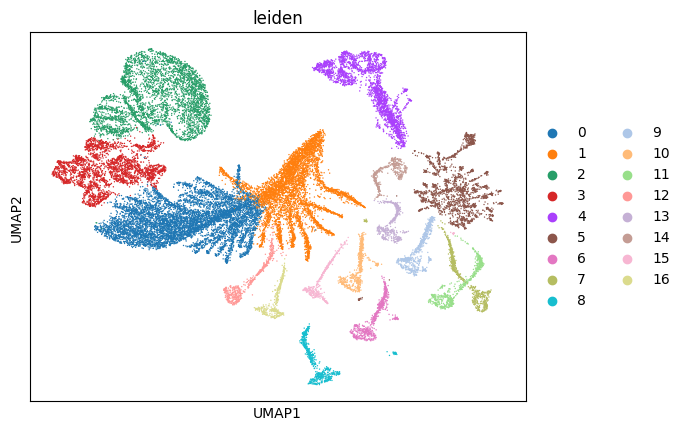

In [29]:
sc.pl.umap(adata, color='leiden')

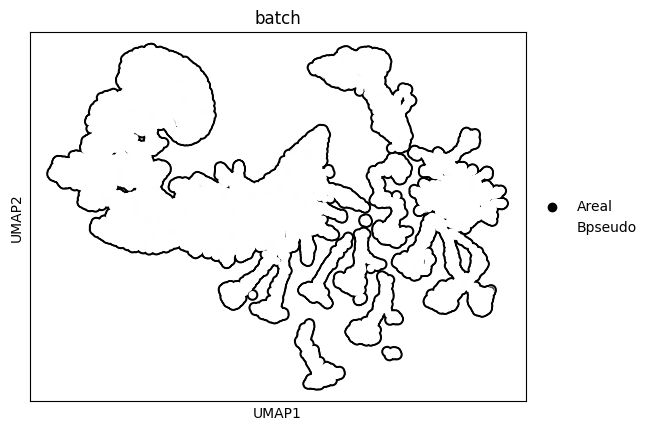

In [53]:
sc.pl.umap(adata, color='batch',add_outline=True,size=100,palette=['black','white'])

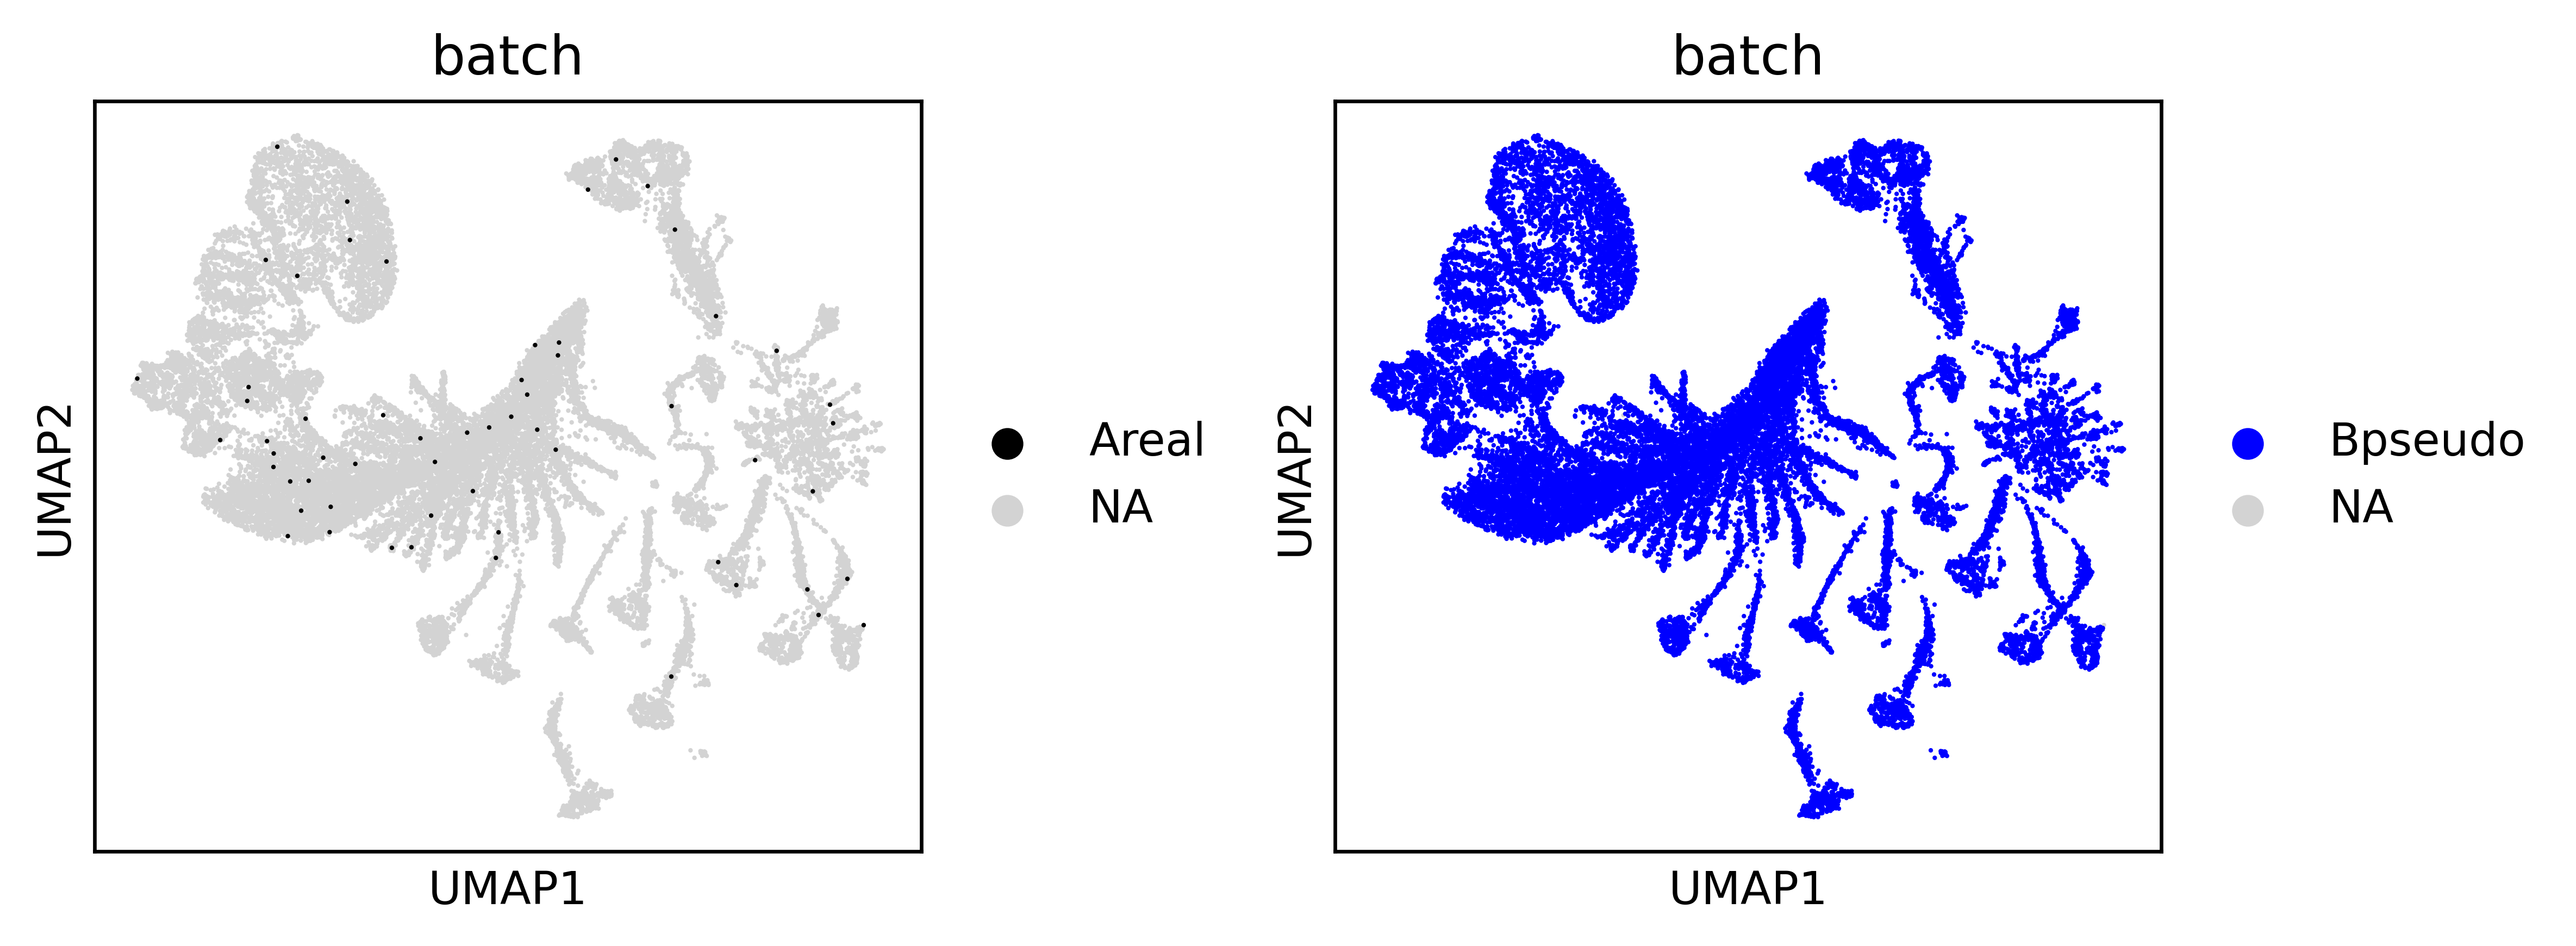

In [67]:
celltype=adata.obs['batch'].unique().tolist() # refined_pred是细胞注释
fig, axes = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True,dpi=600) # nrows和ncols取决于想要的画图个数
x=0;y=0
for i in celltype: #celltype为任何需要并列绘制的list
    fig = sc.pl.umap(adata, color='batch', groups=i, ax=axes[y],show=False,palette=['black','blue'])
    y = y +1 if y <2 else y
    # x = x +1 if x <1 else 0
    # y = y +1 if y <2 and x ==0 else y
plt.show()
plt.close()

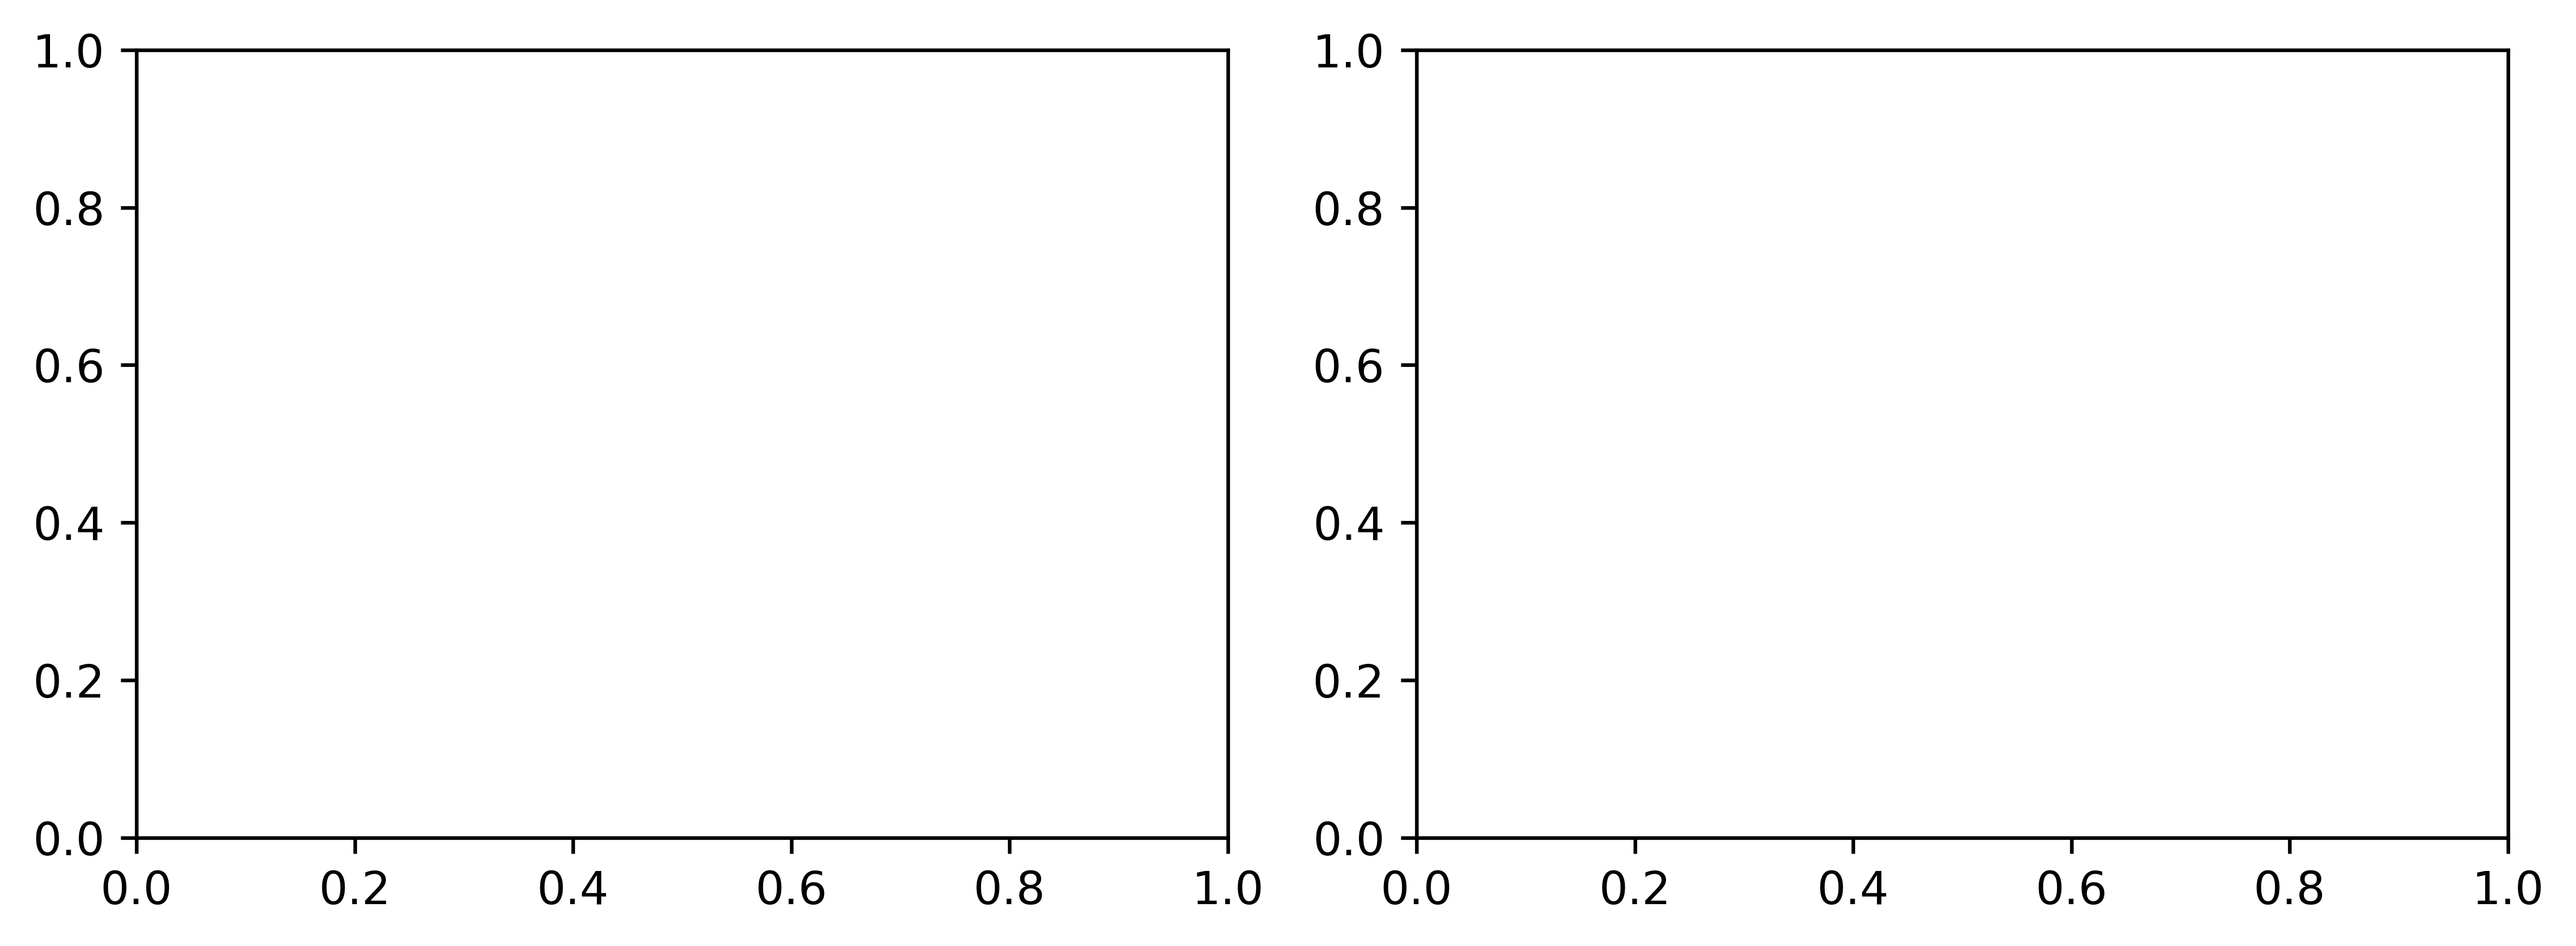

In [61]:
fig

In [31]:
adata_real = adata[adata.obs.batch=='real']

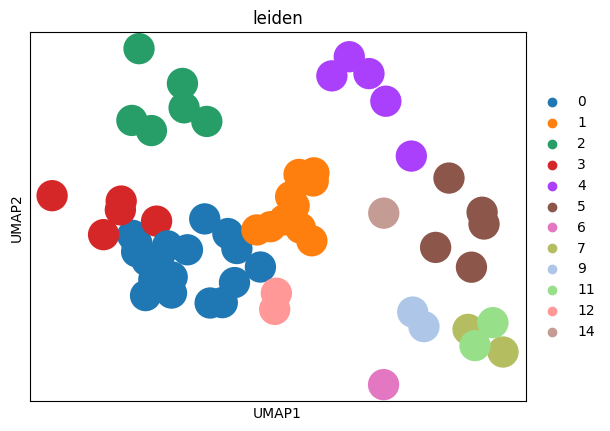

In [35]:
sc.pl.umap(adata_real, color='leiden')

# pseudo spot #

In [15]:
fraction_pie_plot = True
cell_type_distribution_plot = True
n_jobs = -1
GCN_device = 'GPU'

sc_path = paths['sc_path']
ST_path = paths['ST_path']
output_path = paths['output_path']

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
sc_adata = sc.read_csv(paths['sc_path']+"/sc_data.tsv",delimiter='\t')
sc_label = pd.read_table(sc_path+"/sc_label.tsv", sep = '\t', header = 0, index_col = 0, encoding = "utf-8")
sc_label.columns = ['cell_type']
sc_adata.obs['cell_type'] = sc_label['cell_type'].values

cell_type_num = len(sc_adata.obs['cell_type'].unique())
cell_types = sc_adata.obs['cell_type'].unique()

word_to_idx_celltype = {word: i for i, word in enumerate(cell_types)}
idx_to_word_celltype = {i: word for i, word in enumerate(cell_types)}

celltype_idx = [word_to_idx_celltype[w] for w in sc_adata.obs['cell_type']]
sc_adata.obs['cell_type_idx'] = celltype_idx
sc_adata.obs['cell_type'].value_counts()

Neuroblast        128
Choroid Plexus     99
Neural Stem        68
Ependymal          20
Name: cell_type, dtype: int64

In [16]:
spot_num = pseudo_spot_simulation_paras['spot_num']
min_cell_number_in_spot = pseudo_spot_simulation_paras['min_cell_num_in_spot']
max_cell_number_in_spot = pseudo_spot_simulation_paras['max_cell_num_in_spot']
max_cell_types_in_spot = pseudo_spot_simulation_paras['max_cell_types_in_spot']
generation_method = pseudo_spot_simulation_paras['generation_method']
n_jobs = 24

In [17]:
import numpy as np
import random
np.random.seed(0)
random.seed(0)

In [18]:
sc_exp =sc_adata.copy()

In [19]:
output_path

'/data/lyx/hubs/SpaTD/stdgcn/stdGNN_data/results/'

In [20]:
%%time
pseudo_adata = pseudo_spot_generation(sc_adata,
                                      idx_to_word_celltype,
                                      spot_num = pseudo_spot_simulation_paras['spot_num'],
                                      min_cell_number_in_spot = pseudo_spot_simulation_paras['min_cell_num_in_spot'],
                                      max_cell_number_in_spot = pseudo_spot_simulation_paras['max_cell_num_in_spot'],
                                      max_cell_types_in_spot = pseudo_spot_simulation_paras['max_cell_types_in_spot'],
                                      generation_method = pseudo_spot_simulation_paras['generation_method'],
                                      n_jobs = n_jobs
                                      )
data_file = open(paths['output_path']+'/pseudo_ST.pkl','wb')
pickle.dump(pseudo_adata, data_file)
data_file.close()

Generating pseudo-spots:   0%|          | 0/30000 [00:00<?, ?it/s]

CPU times: user 53.5 s, sys: 13.7 s, total: 1min 7s
Wall time: 1min 4s
